 # Petfinder: Bay Area Dog Adoption
 ![Icon](images/pets.jpg)

### Notebook Contents

- Imports
- Train, Test Split
- TFIDF + Logreg Modeling and Feature Union
- Predictions, Confusion Matrix and Misclassified Listing DataFrame Creation

-------

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

In [2]:
dogs = pd.read_csv('./petfinder_data/cleandogs.csv')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
# Creating a list of my categorical columns for later use in modeling
categorical = ['id', 'organization_id', 'name', 'photos', 'status_changed_at', 
               'published_at', 'distance']

In [5]:
dogs.drop(categorical,axis=1, inplace=True)

In [48]:
dogs.shape

(19511, 609)

In [7]:
# Dropping columns from data frame and dummifying categorical columns
X = dogs.drop(columns='days_on_petfinder')
y = dogs['days_on_petfinder']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42)

In [9]:
# Baseline
y.value_counts(normalize=True)

1.0    0.529394
0.0    0.470606
Name: days_on_petfinder, dtype: float64

### TFIDF + Logreg Modeling and Feature Union

In [10]:
get_category = FunctionTransformer(lambda x: x['description'])

In [11]:
get_numerical = FunctionTransformer(lambda x: x.iloc[:,2:])

In [12]:
pipe = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
            ('selector', get_numerical)
        ])),
        ('cat_features', Pipeline([
            ('selector', get_category),
            ('tvec', TfidfVectorizer())
        ]))
    ])),
    ('logreg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000))
])

params = {
    'features__cat_features__tvec__ngram_range':[(1,1), (1,2), (2,2)],
    'features__cat_features__tvec__max_features': [2_000, 5_000, 10_000, 15_000],
    'features__cat_features__tvec__min_df': [2, 3, 4],
    'features__cat_features__tvec__stop_words': [None, 'english'],
}

In [13]:
#SVC!!!!!! and SVM? forest?

In [14]:
gs = GridSearchCV(pipe, param_grid=params, cv=5)

In [15]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7faa867664c0>))])),
                                                                       ('cat_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7faa99281790>)),
                                                                                        ('tvec',
                                                                                         TfidfVectorizer())]))])),
                      

In [16]:
gs.score(X_train, y_train)

0.7647360328036904

In [17]:
gs.score(X_test, y_test)

0.7242910830201572

In [18]:
gs.best_params_

{'features__cat_features__tvec__max_features': 5000,
 'features__cat_features__tvec__min_df': 4,
 'features__cat_features__tvec__ngram_range': (1, 2),
 'features__cat_features__tvec__stop_words': 'english'}

### Predictions, Confusion Matrix and Misclassified Listing DataFrame Creation

In [19]:
# Get predictions
preds = gs.predict(X_test)

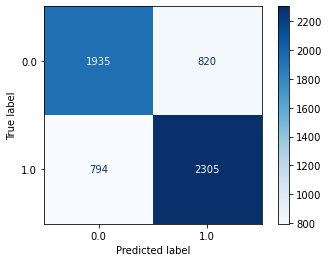

In [20]:
# Confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [21]:
df_classified = pd.DataFrame(data=y_test)
df_classified = df_classified.rename({'days_on_petfinder' : 'actual'}, axis=1)
df_classified['predicted'] = preds
df_classified['misclassified'] = df_classified['actual'] - df_classified['predicted']
df_classified['actual'] = df_classified['actual'].map({1 : 'Speedy_adoption', 0 : 'Slow_adoption'})
df_classified['predicted'] = df_classified['predicted'].map({1 : 'Speedy_adoption', 0 : 'Slow_adoption'})
df_classified['misclassified'] = df_classified['misclassified'].map({1:'Yes', 0:'No', -1:'Yes'})
df_classified = df_classified[df_classified['misclassified'] != 0]

In [22]:
# Sorting so that I only have posts that are misclassified 

misclass_listings = df_classified[df_classified['misclassified'] == 'Yes']

In [35]:
misclass_listings['actual'].value_counts()

Slow_adoption      820
Speedy_adoption    794
Name: actual, dtype: int64

In [36]:
misclass_listings.head()

,actual,predicted,misclassified
7889,Speedy_adoption,Slow_adoption,Yes
7266,Speedy_adoption,Slow_adoption,Yes
7162,Slow_adoption,Speedy_adoption,Yes
10195,Speedy_adoption,Slow_adoption,Yes
5684,Slow_adoption,Speedy_adoption,Yes


In [45]:
result = pd.merge(misclass_listings, dawg, left_index=True, right_index=True)

In [47]:
#result.to_csv('./petfinder_data/misclassified_listings.csv', index = False)